In [2]:
from __future__ import division
%pylab inline
from scipy import stats
from angles import r2d, r2arcs, d2arcs, arcs2r
def arcm2r(theta):
    return arcs2r(theta*60)
import seaborn as sns;sns.set_style('darkgrid')
import lsst.sims.maf.stackers as stackers
import treecorr as tr
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = 19,14
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db
from collections import defaultdict
import treecorr
from itertools import chain
sns.set_context('poster',font_scale=1.4)

Populating the interactive namespace from numpy and matplotlib


In [4]:
Y1 = ModelErrors(ModelType='radial',DitherPattern='field')
Y1.process(sqlWhere='filter = "r" and night < 3650 and fieldRA < %f and fieldDec > %f and fieldRA > 0 and fieldDec < 0' % (np.radians(200), np.radians(-50)))

getting the dither positions from the database:  field
using stackers: [None, <lsst.sims.maf.stackers.ditherStackers.RandomRotDitherPerFilterChangeStacker object at 0x2aaab6358b38>]
old sims
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database Summary with constraint filter = "r" and night < 3650 and fieldRA < 3.490659 and fieldDec > -0.872665 and fieldRA > 0 and fieldDec < 0 for columns ['fieldRA', 'night', 'rotTelPos', 'fieldDec', 'filter']
Found 260016 visits
Running:  ['field dither']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
getting random rotational dithers
Summary: we are using the OpsimRun at /global/homes/h/husni/lsstpsf/simruns/minion_1012, with the translational dither pattern: field. Rotation: random_filter
creating the models at every dither, this will take a while
moving back from moment space to elipticities
finding rhos


In [5]:
%%time
RandomVisitY10 = ModelErrors('radial',rotDithers=None, DitherPattern='random_visit')
RandomVisitY10.process(sqlWhere='filter = "r" and night < 3653 \
and fieldRA < {} and fieldDec > {} \
and fieldRA > 0 and fieldDec < 0'.format(np.radians(200), np.radians(-50)))

getting the dither positions from the database:  randomDitherFieldPerVisit
using stackers: [<lsst.sims.maf.stackers.ditherStackers.RandomDitherFieldPerVisitStacker object at 0x2aaaedbfe048>]
old sims
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Querying database Summary with constraint filter = "r" and night < 3653 and fieldRA < 3.490658503988659 and fieldDec > -0.8726646259971648 and fieldRA > 0 and fieldDec < 0 for columns ['fieldRA', 'fieldDec', 'night']
Found 260016 visits
Running:  ['randomDitherFieldPerVisit dither']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
not using rotational dithering
Summary: we are using the OpsimRun at /global/homes/h/husni/lsstpsf/simruns/minion_1012, with the translational dither pattern: randomDitherFieldPerVisit. Rotation: None
creating the models at every dither, this will take a while
moving back from moment space to elipticities
finding rhos
CPU times: user 47.9 s, sys: 

In [3]:
class ModelErrors():
    
    def __init__(self, ModelType, DitherPattern, rotDithers='random_filter', OpsimRun='minion_1012'):
        self.runName = '/global/homes/h/husni/lsstpsf/simruns/'+OpsimRun 
        self.OpsimRun = OpsimRun
        if "minion" in self.OpsimRun:
            self.rundate = 'old'
        else:
            self.rundate = 'new'
        
        # the available runs are 'minion_1012','minion_1016','alt_sched','feature_baseline_update_10yrsv2'
        self.fwhm = 0.7 #arcsec
        self.sigma = self.fwhm/(2*np.sqrt(2*np.log(2)))
        self.TrM = 2*self.sigma**2
        self.trace_ratio = 2.8933775060156068 # calculated in GalSize.ipynb
        self.PSF.TrM = self.TrM
        self.STAR.TrM = self.TrM
        self.FOVradius = 1.8 #degrees
        self.alpha = 0.01
        self.ModelType = ModelType
        self.survey_area = (np.radians(200),np.radians(50)) # in radians
        self.star_num = 10000
        stars_X = np.random.rand(int(self.star_num))*self.survey_area[0] 
        Y = 0.77*np.random.rand(int(self.star_num))/2 +0.5  #*self.survey_area[1] - self.survey_area[1]
        stars_Y = np.arccos(2*Y-1)-np.pi/2
        stars = np.array((stars_X,stars_Y))
        self.stars = stars.swapaxes(1,0)
        self.DELTA.e = defaultdict(np.array)
        self.DELTA.M = defaultdict(np.array)
        self.STAR.M = defaultdict(np.array)
        self.STAR.e = defaultdict(np.array)
        self.PSF.M = defaultdict(np.array)
        self.PSF.e = defaultdict(np.array)
        self.counter = defaultdict(int)
        self.ksstatistic = []
        self.pvalues = []
        if 'alt_sched' in self.OpsimRun:
            self.DitherPattern='field'
        self.DitherPatterns = {'random_night': 'randomDitherFieldPerNight', 'random_visit':'randomDitherFieldPerVisit',
                              'spiral_night': 'spiralDitherFieldPerNight', 'spiral_visit':'spiralDitherFieldPerVisit',
                              'hex_night': 'hexDitherFieldPerNight', 'hex_visit': 'hexDitherFieldPerVisit',
                              'field':'field'}
        if self.rundate=='new':
            fieldidcolumn = 'fieldId'
            deg = True
        else:
            fieldidcolumn = 'fieldID'
            deg = False
        self.Stackers = {'random_night':stackers.RandomDitherFieldPerNightStacker(fieldIdCol=fieldidcolumn, degrees=deg),
                            'random_visit':stackers.RandomDitherFieldPerVisitStacker(degrees=deg),
                            'spiral_night':stackers.SpiralDitherFieldPerNightStacker(fieldIdCol=fieldidcolumn, degrees=deg),
                            'spiral_visit':stackers.SpiralDitherFieldPerVisitStacker(fieldIdCol=fieldidcolumn, degrees=deg),
                            'hex_night':stackers.HexDitherFieldPerNightStacker(fieldIdCol=fieldidcolumn, degrees=deg),
                            'hex_visit':stackers.HexDitherFieldPerVisitStacker(fieldIdCol=fieldidcolumn, degrees=deg),
                            'field':None} # choosing anything for field -- doesn't really matter
        if DitherPattern not in self.DitherPatterns.keys():
            raise ValueError('Dither Pattern not supported, please choose from:\
                                 field, random_night, random_visit, spiral_night, spiral_visit, hex_night, hex_visit')
        else:
            self.DitherPattern = self.DitherPatterns[DitherPattern]
            self.Stacker = [self.Stackers[DitherPattern]]
        self.rotDitherPattern = rotDithers
        if self.rotDitherPattern=='random_filter':
            self.Stacker.append(stackers.RandomRotDitherPerFilterChangeStacker())

        self.savedStarsAngles = {tuple(k):[0] for k in self.stars}
        
        # Getting requirements on rho and xi_+ from HSC data. 
        HSCCosmicShear = np.loadtxt('HSCS16A_combinedarea_1000rea_full_xi_p.mean_sqrtvar')
        self.reqs_r = arcm2r(1)*HSCCosmicShear[:,0]
        self.HSCCosmicShear_xip = HSCCosmicShear[:,1]/2.6
        rho_reqs = np.loadtxt('rho_requirements.txt')
        lsst_area = 18000.
        hsc_area = 136.
        self.rho25_reqs = 0.02/self.alpha * np.sqrt(hsc_area/lsst_area) * rho_reqs[:,2]/(self.trace_ratio)**2
        self.rho134_reqs = np.sqrt(hsc_area/lsst_area) * rho_reqs[:,1]/(self.trace_ratio)
      
    class PSF:
        '''empty namespace to organise results into
        '''
        pass
    
    class STAR:
        '''empty namespace to organise results into
        '''
        pass
    
    class DELTA:
        '''empty namespace to organise results into
        '''
        pass

    def getPositions(self,sqlWhere):
        '''uses OpSim to find all dithered positions given some constraint sqlWhere
        '''
        print ('getting the dither positions from the database: ', self.DitherPattern)
        print ('using stackers:', self.Stacker)
        
        if self.Stacker[0]==None:
            self.Stacker=self.Stacker[1:]
        if 'minion' not in self.OpsimRun and 'feature' not in self.OpsimRun:
            print("new sim")
            outDir = 'dither_test'
            myBundles = {}
            nside = 128 
            resultsDb = db.ResultsDb(outDir=outDir)

            opsdb = db.OpsimDatabase(self.runName+'.db')
            slicer = slicers.HealpixSlicer(lonCol='fieldRA', latCol='fieldDec', nside=nside)
            
            metric = metrics.PassMetric()
            print(self.Stacker)
            if self.Stacker==[None]:
                myBundles['field dither'] = metricBundles.MetricBundle(metric, slicer, constraint=sqlWhere, 
                                                                    runName=self.runName,
                                                                    metadata='field dither')
            else:
                myBundles['field dither'] = metricBundles.MetricBundle(metric, slicer, constraint=sqlWhere, 
                                                                   stackerList=self.Stacker, runName=self.runName,
                                                                   metadata='field dither')
            bgroup = metricBundles.MetricBundleGroup(myBundles, opsdb, outDir=outDir, resultsDb=resultsDb)
            bgroup.runAll() 
        elif 'minion' in self.OpsimRun:
            print("old sims")
            opsdb = db.OpsimDatabaseV3(self.runName + '_sqlite.db')
            outDir = 'dither_test'
            resultsDb = db.ResultsDb(outDir=outDir)
            if self.DitherPattern=='field':
                slicer = slicers.HealpixSlicer(nside=64, lonCol='fieldRA', latCol='fieldDec', latLonDeg=False)
            else:
                slicer = slicers.HealpixSlicer(nside=64, lonCol=self.DitherPattern+'Ra', 
                                               latCol=self.DitherPattern+'Dec', latLonDeg=False)
            sqlconstraint = sqlWhere
            metric = metrics.CountMetric(col='night')

            bundle = metricBundles.MetricBundle(metric, slicer, sqlconstraint, runName=self.runName, 
                                            stackerList=self.Stacker)
            bgroup = metricBundles.MetricBundleGroup({self.DitherPattern+' dither':bundle}, 
                                                     opsdb, outDir=outDir, resultsDb=resultsDb)
            bgroup.runAll()
        if 'feature' in self.OpsimRun:
            posRA, posDec = np.load('simruns/feature_baseline.npy')
        elif self.DitherPattern=='field':
            posRA = bgroup.simData['fieldRA']
            posDec = bgroup.simData['fieldDec']
        else:
            posRA = bgroup.simData[self.DitherPattern+'Ra']
            posDec = bgroup.simData[self.DitherPattern+'Dec']
        pos = np.array((posRA,posDec))
        if 'minion' not in self.OpsimRun:
            pos *= np.radians(1)
        self.positions = pos.swapaxes(1,0)
        try:
            if np.logical_and(self.DitherPattern=='field', 'minion' in self.OpsimRun):
                self.rotTelPos = np.zeros(len(bgroup.simData['rotTelPos']))
            else:
                self.rotTelPos = np.random.uniform(-np.pi/2,np.pi/2,len(bgroup.simData['rotTelPos']))

            print('getting random rotational dithers')

        except: 
            print('not using rotational dithering')
            self.rotTelPos = None
        print ('Summary: we are using the OpsimRun at {}, with the translational dither pattern: {}. Rotation: {}'.format(self.runName,
                                                                                                                          self.DitherPattern,
                                                                                                                          self.rotDitherPattern))
        
    def M2e(self):
        ''' go back from 2nd moment space to elipticities
        '''
        print ('moving back from moment space to elipticities')
        for pos in self.PSF.M.keys():
            Mxx, Mxy, Myy = self.DELTA.M[pos]
            self.DELTA.e[pos] = np.array([(Mxx-Myy)/self.PSF.TrM, Mxy*2/self.PSF.TrM])
            Mxx, Mxy, Myy = self.STAR.M[pos]
            self.STAR.e[pos] = np.array([(Mxx-Myy)/self.STAR.TrM, Mxy*2/self.STAR.TrM])
            Mxx, Mxy, Myy = self.PSF.M[pos]
            self.PSF.e[pos] = np.array([(Mxx-Myy)/self.PSF.TrM, Mxy*2/self.PSF.TrM])
    
    def process(self,sqlWhere):
        ''' runs all analysis methods 
        '''
        self.getPositions(sqlWhere)
        print ('creating the models at every dither, this will take a while')
        for i in range(len(self.stars)):
            self.getModel(position_num=i)
        self.M2e()
        self.getRhos()
        self.rhos2errors()

    def getRhos(self):
        ''' method to get the rho statistics, needs a model, and traces for rhos 2 through 5.
        '''
        print ('finding rhos')
        X, Y = map(lambda i: np.array([key[i] for key in self.DELTA.e.keys()]), (0,1))
        de1, de2 = map(lambda i:np.array([val[i] for val in self.DELTA.e.values()]), (0,1))
        psfe1, psfe2 = map(lambda i: np.array([val[i] for val in self.PSF.e.values()]), (0,1))
        stare1, stare2 = map(lambda i: np.array([val[i] for val in self.STAR.e.values()]), (0,1))
        condition= np.logical_and(np.logical_and(np.degrees(X)>5,np.degrees(Y)<-5), np.logical_and(np.degrees(X)<195,np.degrees(Y)>-45))
        X = X[condition]
        Y = Y[condition]
        de1 = de1[condition]
        de2 = de2[condition]
        psfe1 = psfe1[condition]
        psfe2 = psfe2[condition]
        stare1 = stare1[condition]
        stare2 = stare2[condition]
        
        decat = treecorr.Catalog(g1=de1, g2=de2, ra=X, dec=Y, ra_units='radians', dec_units='radians')
        psfcat = treecorr.Catalog(g1=psfe1, g2=psfe2, ra=X, dec=Y, ra_units='radians', dec_units='radians')
        starcat = treecorr.Catalog(g1=stare1, g2=stare2, ra=X, dec=Y, ra_units='radians', dec_units='radians')
        
        min_sep=0.01 # in degrees
        max_sep=10 # in degrees
        nbins=24 # number of bins
        
        dedecorr = treecorr.GGCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, sep_units='degrees')
        dedecorr.process(decat)
        dede_xip = dedecorr.xip
        dede_xim = dedecorr.xim
        self.rho1_sigma = dedecorr.varxi**0.5
        self.r = np.exp(dedecorr.meanlogr)
        self.rho1 = dede_xip
        self.rho1_im = dede_xim

        edecorr = treecorr.GGCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, sep_units='degrees')
        edecorr.process(psfcat, decat)
        ede_xip = edecorr.xip
        ede_xim = edecorr.xim
        
        self.rho2 = ede_xip
        self.rho2_im = ede_xim
        self.rho2_sigma = edecorr.varxi**0.5
        

        self.size_error_ratio = 0.001

        edtedtcorr = treecorr.GGCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, sep_units='degrees')
        edtedtcorr.process(psfcat, psfcat)
        edtedt_xip = edtedtcorr.xip * self.size_error_ratio**2
        edtedt_xim = edtedtcorr.xim * self.size_error_ratio**2

        self.rho3 = edtedt_xip
        self.rho3_im = edtedt_xim
        self.rho3_sigma = edtedtcorr.varxi**0.5 * self.size_error_ratio**2

        deedtcorr = treecorr.GGCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, sep_units='degrees')
        deedtcorr.process(decat, psfcat)
        deedt_xip = deedtcorr.xip * self.size_error_ratio
        deedt_xim = deedtcorr.xim * self.size_error_ratio

        self.rho4 = deedt_xip
        self.rho4_im = deedt_xim
        self.rho4_sigma = deedtcorr.varxi**0.5 * self.size_error_ratio

        eedtcorr = treecorr.GGCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, sep_units='degrees')
        eedtcorr.process(psfcat, psfcat)
        eedt_xip = eedtcorr.xip * self.size_error_ratio
        eedt_xim = eedtcorr.xim * self.size_error_ratio

        self.rho5 = eedt_xip
        self.rho5_im = eedt_xim
        self.rho5_sigma = eedtcorr.varxi**0.5 * self.size_error_ratio
            
        # star shape correlation:
        starcorr = treecorr.GGCorrelation(min_sep=min_sep, max_sep=max_sep, nbins=nbins, sep_units='degrees')
        starcorr.process(starcat)
        self.xip_sigma = starcorr.varxi**0.5
        self.xip = starcorr.xip
        self.xim = starcorr.xim
        
    def rhos2errors(self):
        ''' propagates rho statistics into shear errors 
        '''

        self.delta_xip = 2 * (self.size_error_ratio * self.trace_ratio) * self.xip\
                    + (self.trace_ratio)**2 * self.rho1\
                    - self.alpha * (self.trace_ratio) * self.rho2\
                    + (self.trace_ratio)**2 * self.rho3\
                    + (self.trace_ratio)**2 * self.rho4\
                    - self.alpha * (self.trace_ratio) * self.rho5
        
        self.delta_xip_sigma = np.sqrt( self.trace_ratio**4 * self.rho1_sigma**2 \
                                      + self.alpha**2 * self.trace_ratio**2 * self.rho2_sigma**2 \
                                      + 4 * self.size_error_ratio**2 *self.trace_ratio**2 * self.xip_sigma**2 \
                                      + self.trace_ratio**4 * self.rho3_sigma**2 \
                                      + self.trace_ratio**4 * self.rho4_sigma**2 \
                                      + self.alpha**2 * self.trace_ratio**2 * self.rho5_sigma**2)
                                  
    def getModel(self,position_num):
        ''' method to create a radial pattern (one of the overly simplified models),
            e = 0.05* distance from origin.
            New algorithm loops over each star, finding the dither positions at which it would
            be visible -- then 
        '''
        from angles import r2d, r2arcs, d2arcs
        star_pos = self.stars[position_num]
        innerDithers = self.positions[np.sqrt((self.positions[:,0]-star_pos[0])**2+(self.positions[:,1]-star_pos[1])**2)<np.radians(self.FOVradius)]
        try: 
            rotDithers = self.rotTelPos[np.sqrt((self.positions[:,0]-star_pos[0])**2+(self.positions[:,1]-star_pos[1])**2)<np.radians(self.FOVradius)]
        except: pass
        
        if len(innerDithers) < 1:
            return
        if self.ModelType == 'radial':
            stare1, stare2, psfe1, psfe2 = self.RadialModel(star_pos=star_pos, innerDithers=innerDithers)
        elif self.ModelType == 'horizontal':
            stare1, stare2, psfe1, psfe2 = self.HorizontalModel(star_pos=star_pos, innerDithers=innerDithers, rotDithers=rotDithers)
        star_pos = tuple(star_pos)
        starMxx = 0.5*self.STAR.TrM*(stare1+1)
        starMxy = 0.5*self.STAR.TrM*stare2
        starMyy = 0.5*self.STAR.TrM*(-stare1+1)
        psfMxx = 0.5*self.PSF.TrM*(psfe1+1)
        psfMxy = 0.5*self.PSF.TrM*psfe2
        psfMyy = 0.5*self.PSF.TrM*(-psfe1+1)
        angles = np.array([r2d(0.5*np.arctan2(e2,e1)) for e2,e1 in zip(stare2,stare1)]) 
        self.savedStarsAngles[star_pos] = angles

        deltaMxx = starMxx - psfMxx
        deltaMxy = starMxy - psfMxy
        deltaMyy = starMyy - psfMyy

        self.counter[star_pos] = len(innerDithers)
        self.STAR.M[star_pos] = np.array([np.mean(starMxx), np.mean(starMxy), np.mean(starMyy)])
        self.PSF.M[star_pos] = np.array([np.mean(psfMxx), np.mean(psfMxy), np.mean(psfMyy)])
        self.DELTA.M[star_pos] = np.array([np.mean(deltaMxx), np.mean(deltaMxy), np.mean(deltaMyy)])

    def RadialModel(self, star_pos, innerDithers):
        rel_X, rel_Y = star_pos[0] - innerDithers[:,0], star_pos[1] - innerDithers[:,1]
        r = np.sqrt(rel_X**2+rel_Y**2)
        r[r<0.0237]=0 # 0.0237 is 80% of the LSST FOV radius in radians.
        r[r>=0.0237]=0.08
        theta = np.arctan((rel_Y)/(rel_X))
        stare1 = r*np.cos(2*theta)
        stare2 = r*np.sin(2*theta)
        psfe1 = stare1/1.06
        psfe2 = stare2/1.06
        return stare1, stare2, psfe1, psfe2

    def HorizontalModel(self, star_pos, innerDithers, rotDithers):
        '''this method creates a radial model of e_psf = 0.6 and the residual is 3%.'''
        stare1 = np.cos(2*rotDithers)/5
        stare2 = np.sin(2*rotDithers)/5
        psfe1 = stare1/1.03
        psfe2 = stare2/1.03
        return stare1, stare2, psfe1, psfe2

In [7]:
colors = sns.color_palette('colorblind')

No handles with labels found to put in legend.


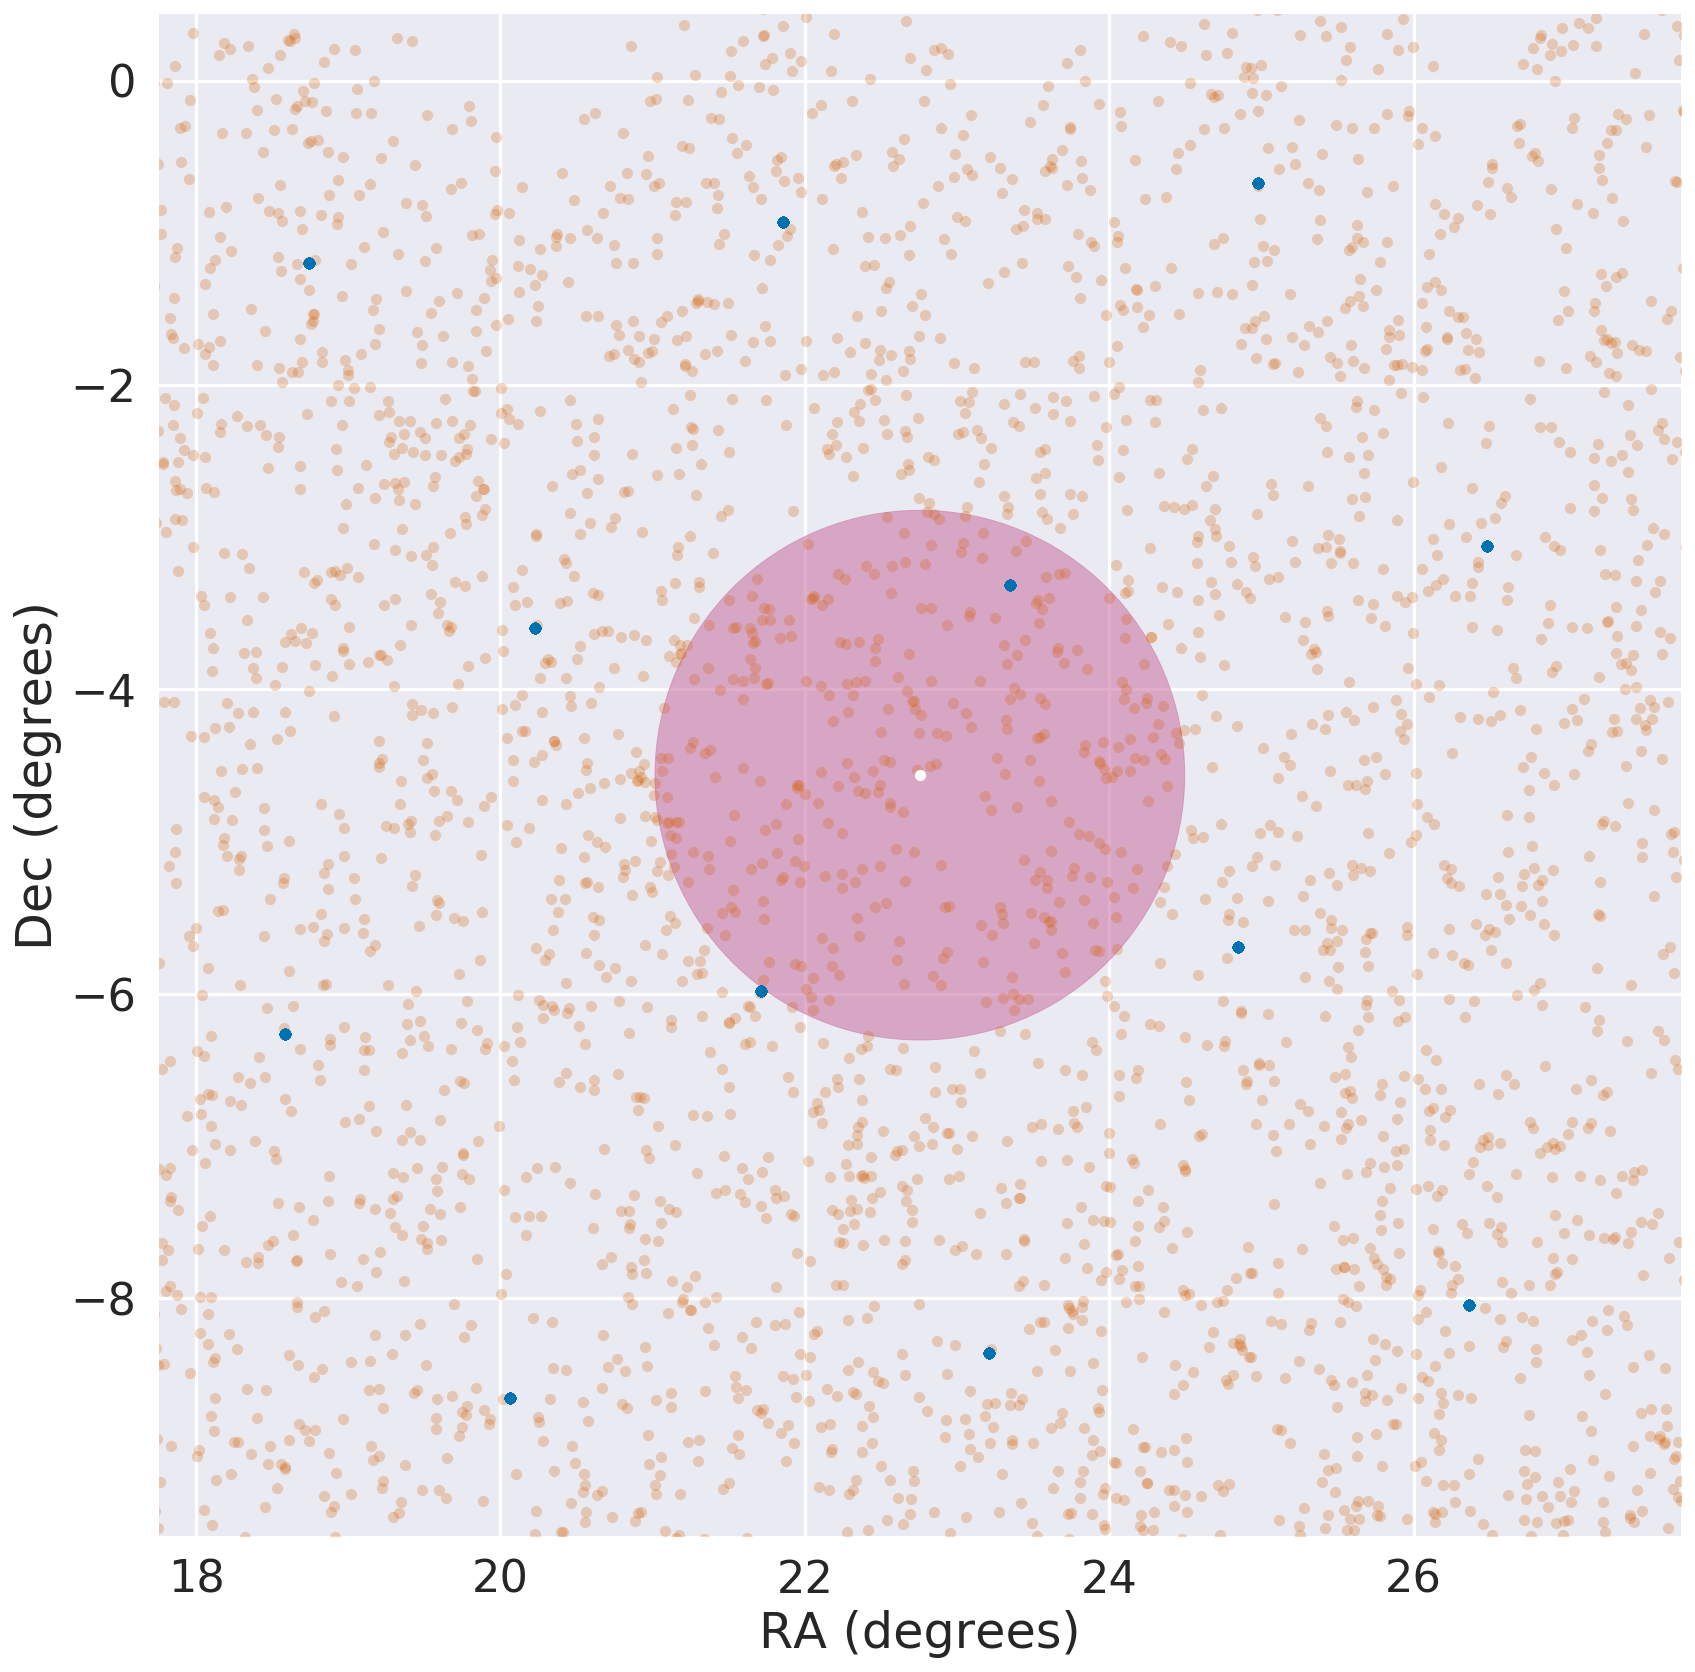

In [26]:
circle1 = plt.Circle((180/np.pi*RandomVisitY10.stars[20,0], 180/np.pi*RandomVisitY10.stars[20,1]),1.74,alpha=0.6,color=colors[3])

fig, ax = plt.subplots()
ax.add_artist(circle1)

ax.plot(180/np.pi*RandomVisitY10.positions[:,0], 180/np.pi*RandomVisitY10.positions[:,1],'.', color=colors[2], alpha=0.25)
ax.plot(180/np.pi*RandomVisitY10.stars[20,0], 180/np.pi*RandomVisitY10.stars[20,1], 'w.')

ax.set_xlim((180/np.pi*RandomVisitY10.stars[20,0]-5,180/np.pi*RandomVisitY10.stars[20,0]+5))
ax.set_ylim((180/np.pi*RandomVisitY10.stars[20,1]-5,180/np.pi*RandomVisitY10.stars[20,1]+5))

ax.set_aspect('equal')
ax.set_xlabel('RA (degrees)')
ax.set_ylabel('Dec (degrees)')


ax.plot(180/np.pi*Y1.positions[:,0], 180/np.pi*Y1.positions[:,1],'.', color=colors[0])
# ax.plot(180/np.pi*Y1.stars[20,0], 180/np.pi*Y1.stars[20,1], 'w.')

# ax.set_xlim((180/np.pi*Y1.stars[20,0]-5,180/np.pi*Y1.stars[20,0]+5))
# ax.set_ylim((180/np.pi*Y1.stars[20,1]-5,180/np.pi*Y1.stars[20,1]+5))
# ax.set_aspect('equal')
# ax.set_xlabel('RA (degrees)')
# ax.set_ylabel('Dec (degrees)')
plt.legend()
